Begun 8/3/24

The goal of this notebook is to take the method from pixell_sim_bincount_test_01_20240716.ipynb and apply it to a range of depth-1 masks of varying sky area to see if they give the same results.

I am using a bin_size of 25 over the range ell=25-5000 here to be somewhat similar to what we want to use for our real spectra.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Loading in CAMB input spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [5]:
# Functions for calculating power spectra from depth-1 and reference map to use as noise in sims
def make_tapered_mask(map_to_mask,filter_radius=1.0,plot=False):
    """
        Makes a mask for a given map based on where the ivar map is nonzero.
        Also apodizes the mask and gets the indices of where the apodized
        mask is not equal to one (everything tapered or outside the mask)
        in order to set all points but those to zero after filtering.
    """
    footprint = 1*map_to_mask.astype(bool)
    mask = nw.apod_C2(footprint,filter_radius)
    
    # Getting points to set to zero after filtering
    indices = np.nonzero(mask != 1)
    
    if plot:
        eshow(mask, **keys_eshow)
    
    return mask, indices

def spectrum_from_maps(map1, map2, b_ell_bin_1, b_ell_bin_2, w2, bins):
    """Function modified from the one in ACT DR4/5 NB7 for binning a power spectrum for two maps.
       This function does account for a window correction for the apodizing at this point.
       Also accounts for a beam correction using a beam defined by b_ell.
    """
    spectrum = np.real(map1*np.conj(map2))

    # Dividing by an approx. correction for the loss of power from tapering
    spectrum /= w2

    modlmap = map1.modlmap()

    # Bin the power spectrum
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount

    binned /= (b_ell_bin_1*b_ell_bin_2)

    return binned, bincount

In [4]:
# Generating test pixell map in same shape as a depth-1 map
obs_list = "/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/dr6_depth1_test_map_list.txt"
with open(obs_list) as f:
    lines = f.read().splitlines()

In [6]:
def get_hivon_fsky_enmap(mask):
    imap = mask/np.max(mask)
    w2w4 = (np.mean(imap**2.)**2./np.mean(imap**4.))
    skyarea = imap.area()/(4.*np.pi)*w2w4
    return skyarea

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:34<00:00,  4.54s/it]


Map name: depth1_1494463440_pa4_f150_map.fits
w2: 0.33581580180667353
w2w4: 0.34284425609329683
f_sky w/w2w4: 0.013837504089267325


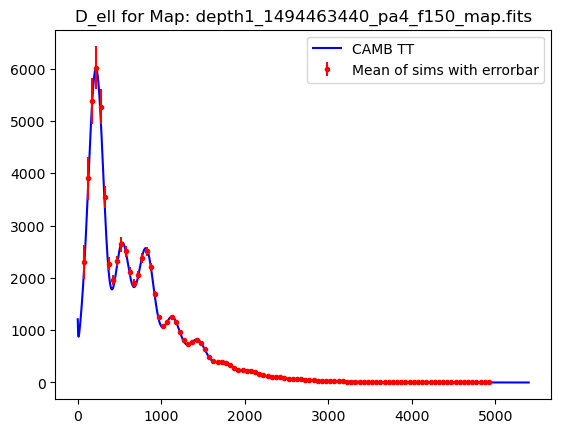

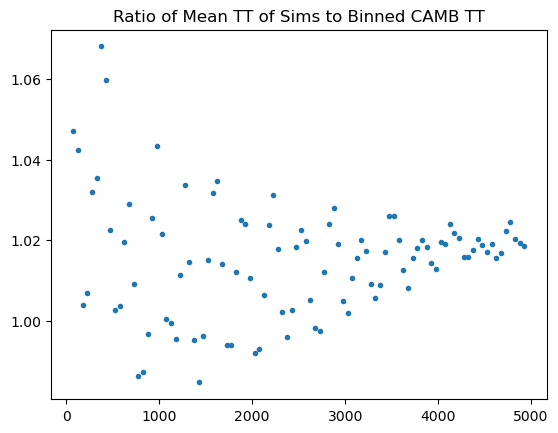

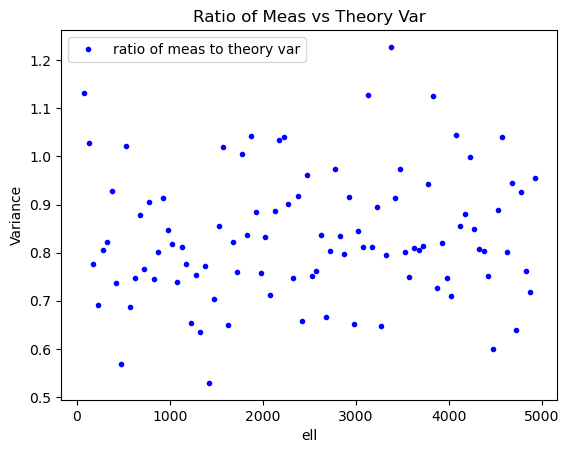

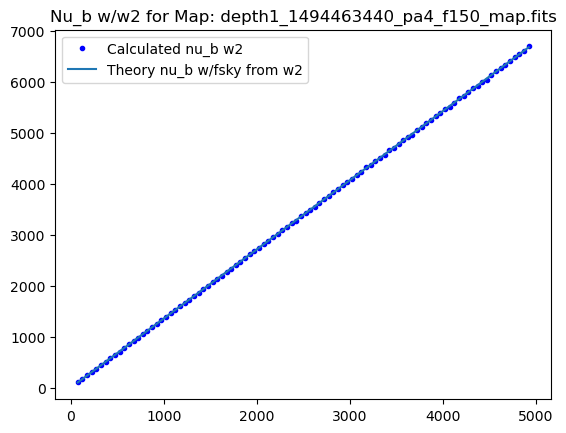

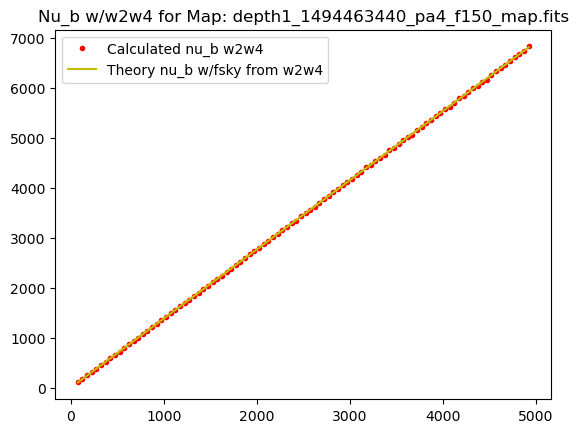

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:54<00:00,  3.54s/it]


Map name: depth1_1494478923_pa6_f150_map.fits
w2: 0.03177068651713765
w2w4: 0.04081371309731792
f_sky w/w2w4: 0.0009562278167960936


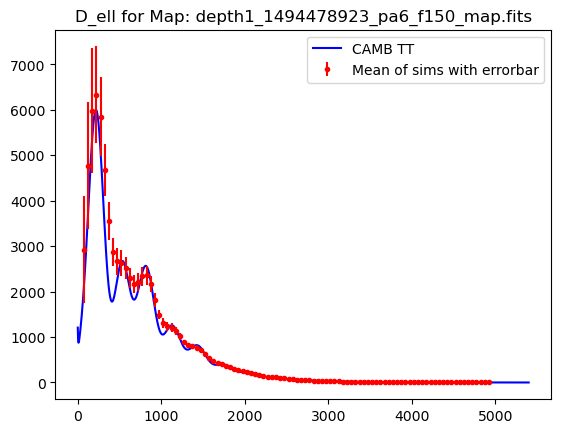

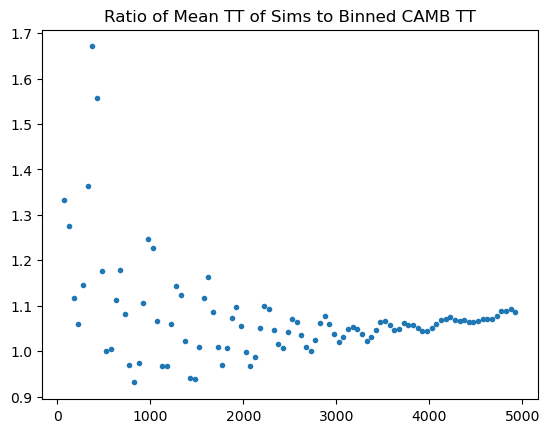

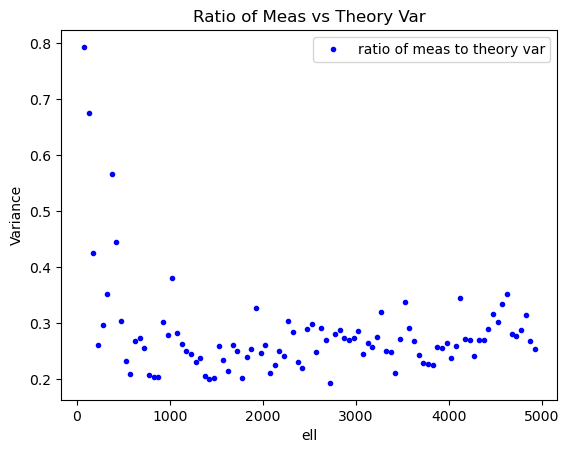

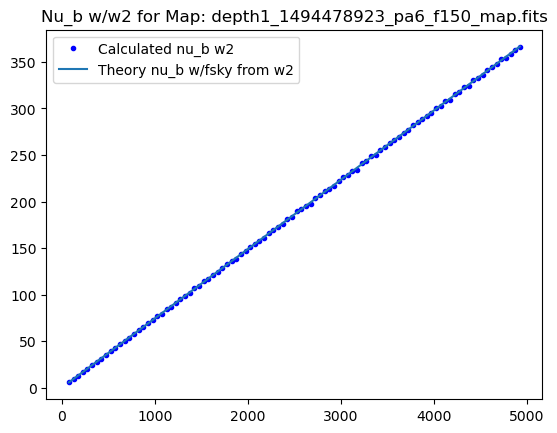

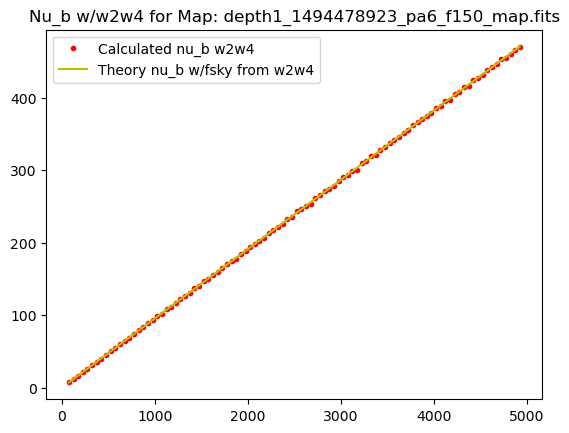

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:19<00:00,  4.40s/it]


Map name: depth1_1494565020_pa5_f150_map.fits
w2: 0.17150570396315654
w2w4: 0.18302080782549815
f_sky w/w2w4: 0.006417677461084236


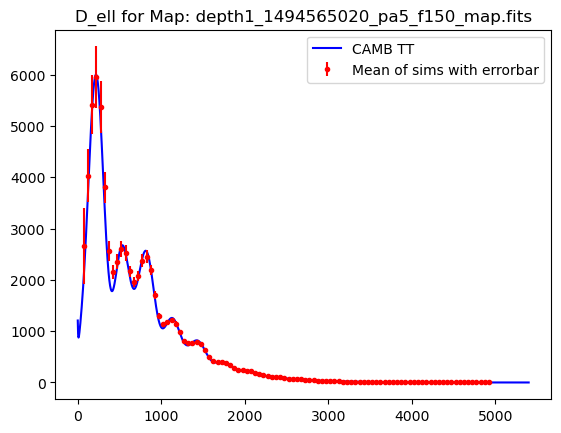

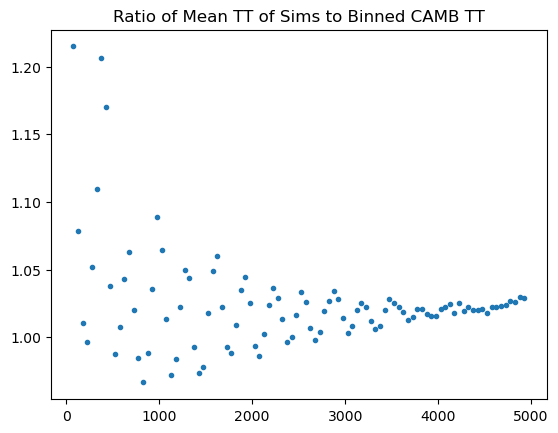

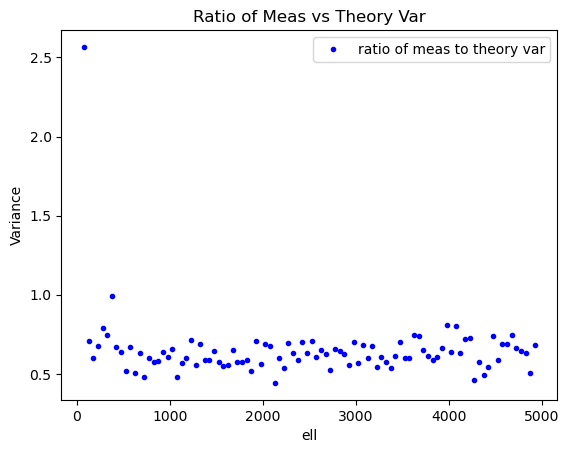

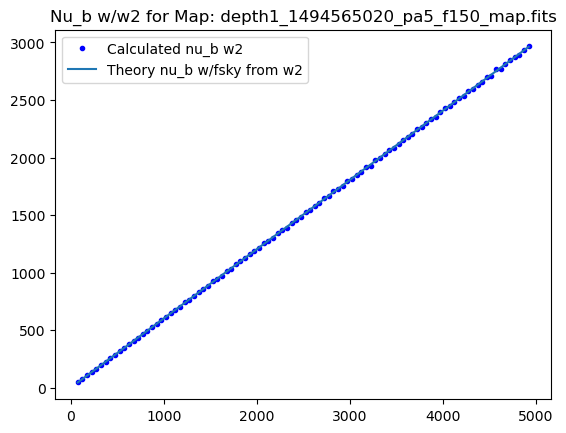

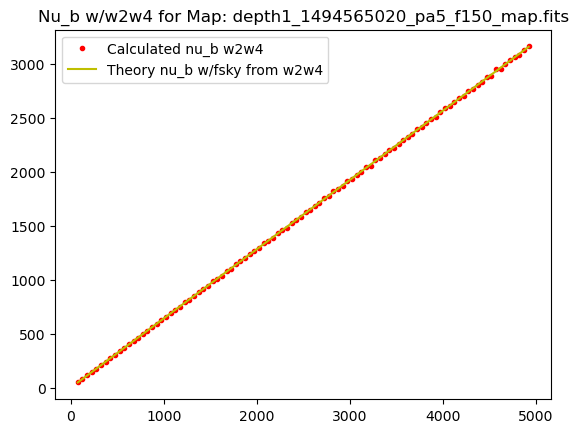

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:29<00:00,  3.90s/it]


Map name: depth1_1494587192_pa5_f150_map.fits
w2: 0.11731976722540897
w2w4: 0.1250077584778272
f_sky w/w2w4: 0.0030060935106204292


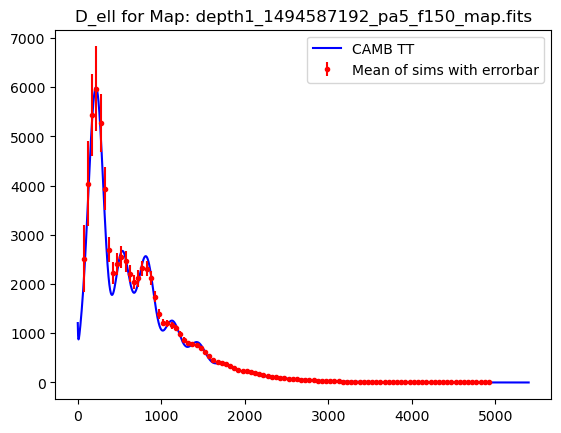

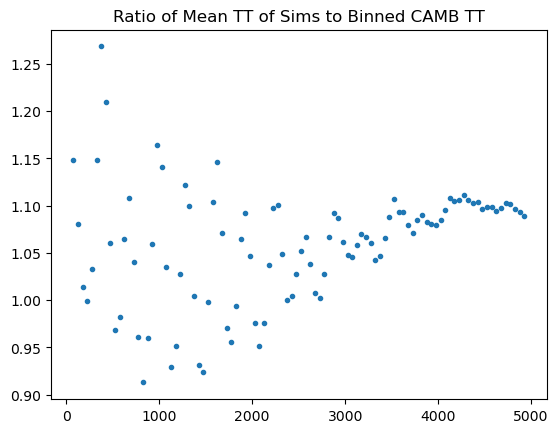

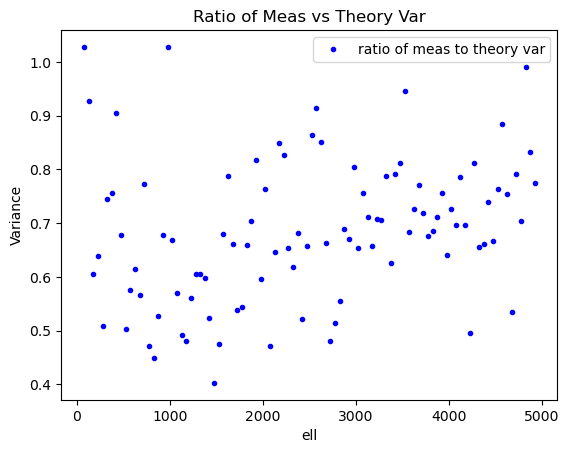

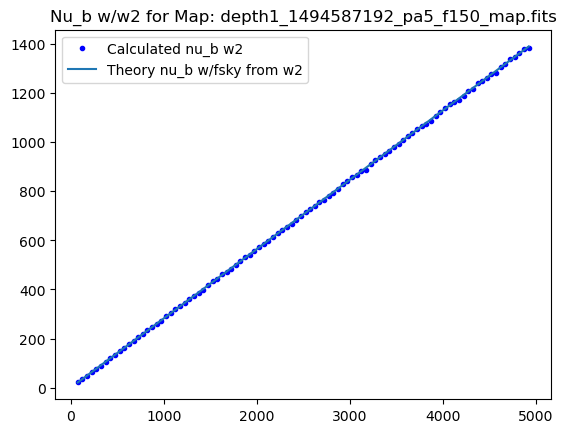

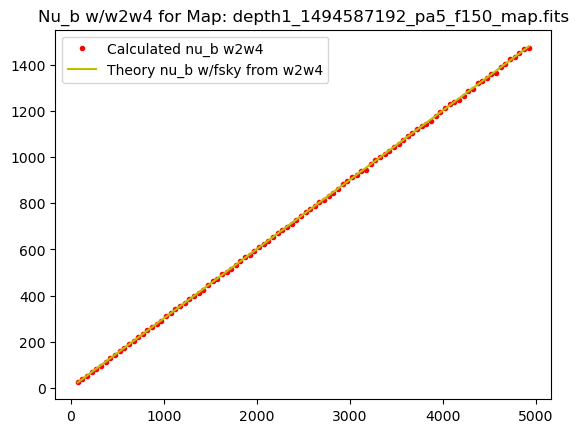

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:18<00:00,  4.39s/it]


Map name: depth1_1494735603_pa5_f150_map.fits
w2: 0.34012199671085447
w2w4: 0.35048143066594717
f_sky w/w2w4: 0.015007955702838874


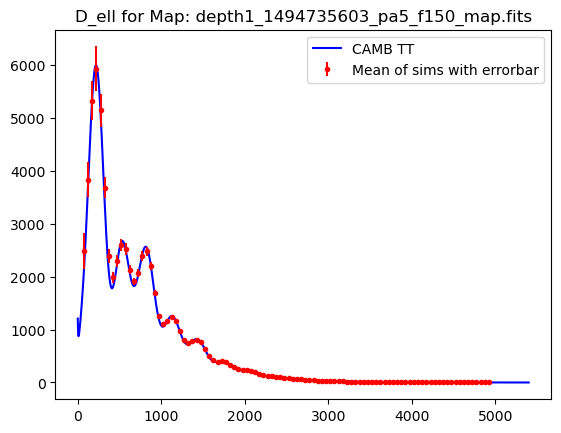

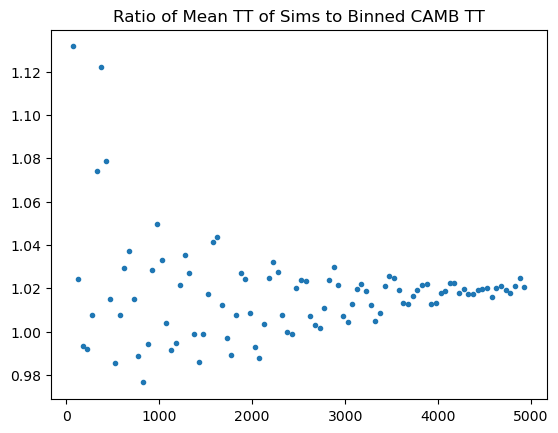

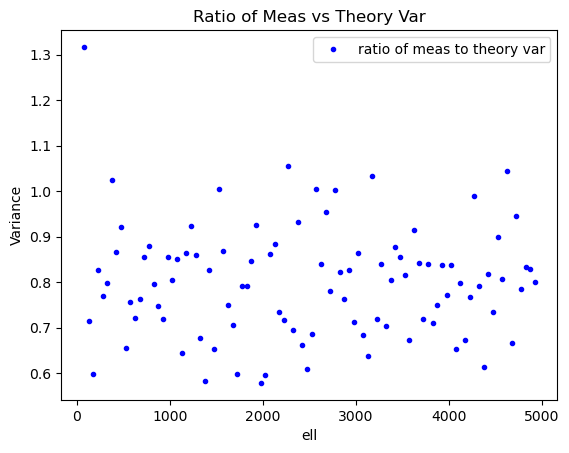

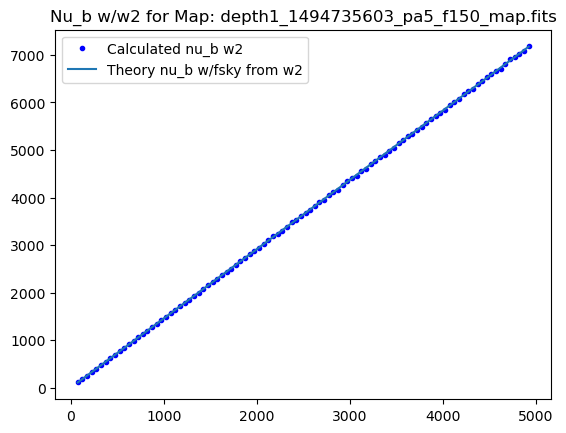

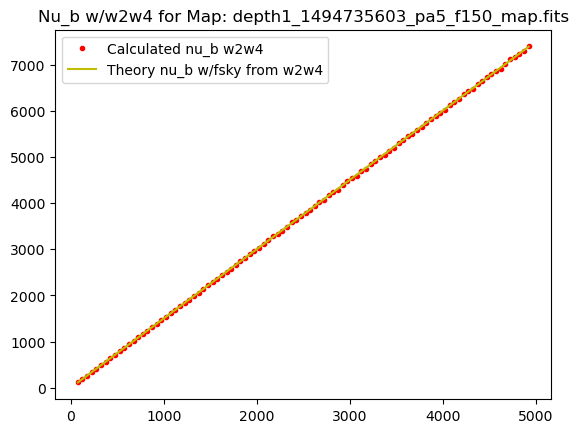

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:02<00:00,  3.62s/it]


Map name: depth1_1494761700_pa4_f150_map.fits
w2: 0.5807091933773068
w2w4: 0.5969310979151355
f_sky w/w2w4: 0.012571510133346571


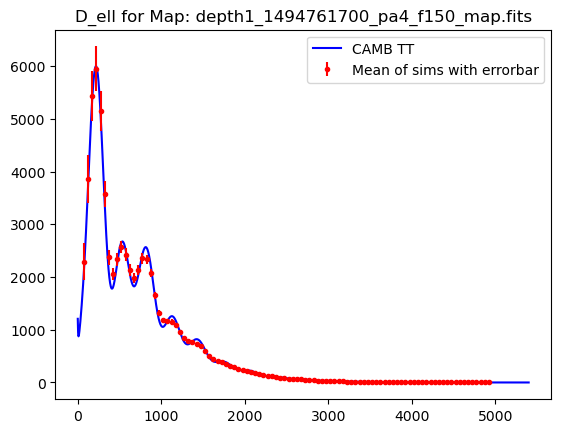

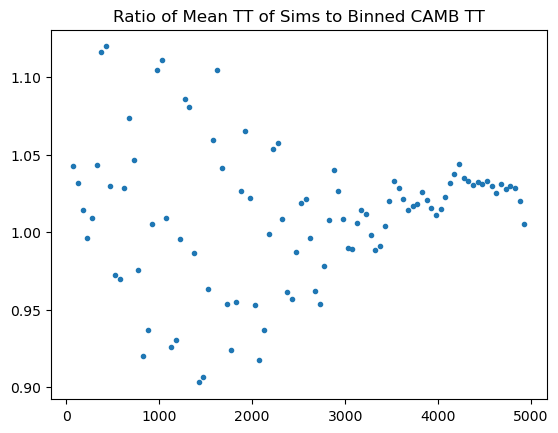

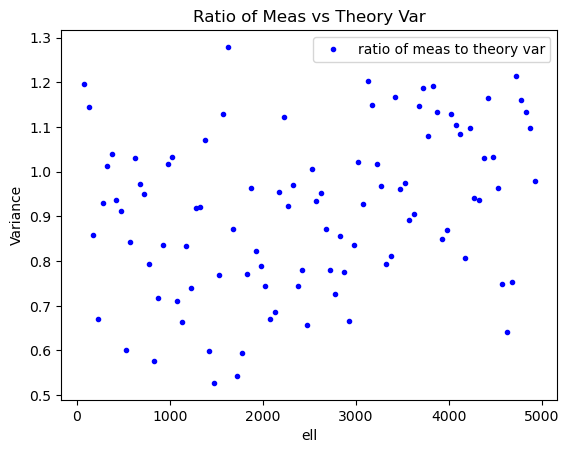

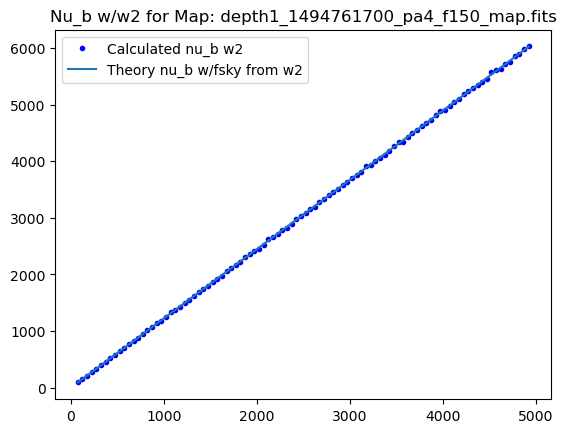

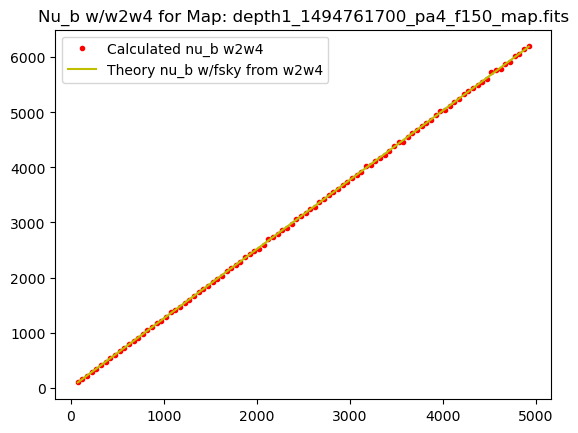

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:54<00:00,  3.54s/it]


Map name: depth1_1513422389_pa6_f150_map.fits
w2: 0.45571165964844285
w2w4: 0.4696870757704322
f_sky w/w2w4: 0.011342193634250559


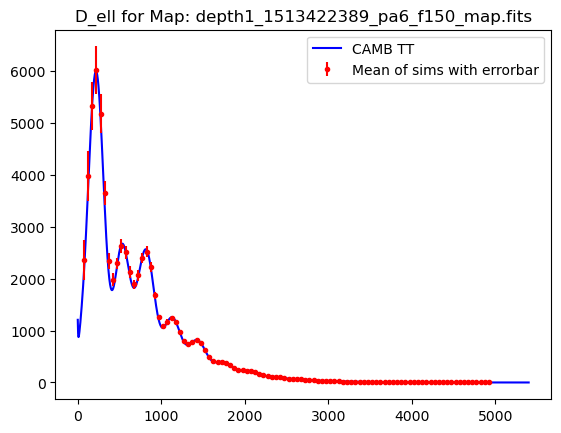

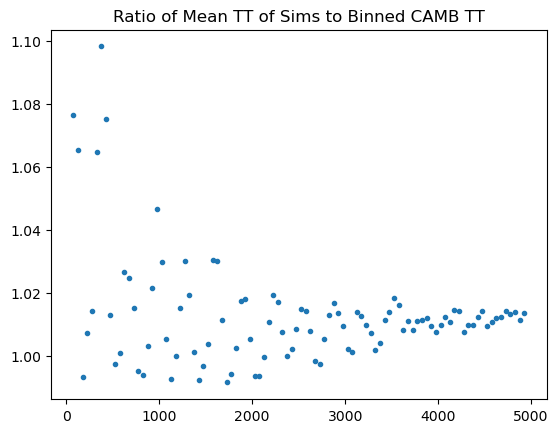

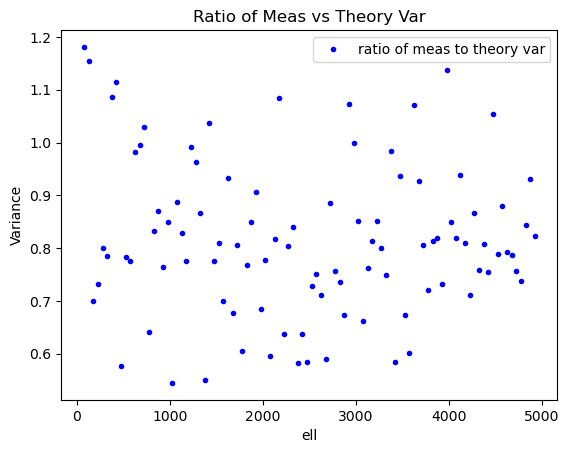

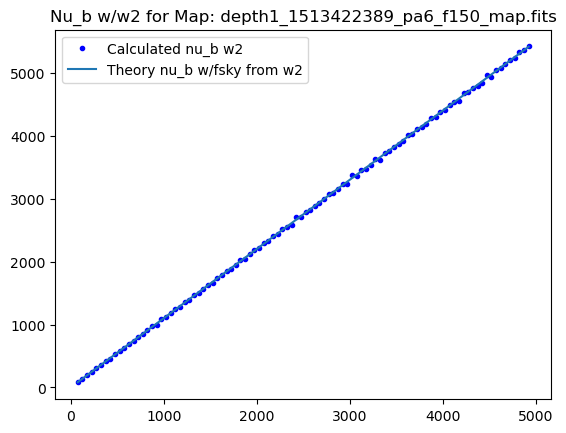

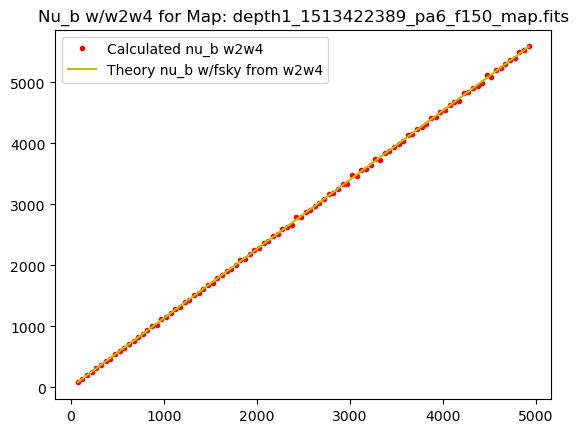

In [14]:
# For several of the different depth-1 masks, generate pixell sims using alm from CAMB to compare
# the measured variance to the theoretical variance

indices = [0,5,10,15,20,25,30] # which depth-1 maps to use - starting with five random ones with different shapes
for idx in indices:
    depth1_path = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/' + lines[idx]
    depth1_T = enmap.read_map(depth1_path)[0]
    ivar_path = depth1_path[:-8] + "ivar.fits"
    depth1_ivar = 1.0*enmap.read_map(ivar_path) # 1.0 for T noise - shouldn't matter here; we just want the ivar shape
    depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=False)
    
    w2 = np.mean(depth1_mask**2)
    w2w4 = np.mean(depth1_mask**2)**2 / np.mean(depth1_mask**4)
    
    N_sims = 100
    lmin = 50
    lmax = 5000
    bin_size = 50
    
    bins = np.arange(lmin, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.
    
    spectra = []
    
    for i in tqdm(range(N_sims)):
        alm = hp.sphtfunc.synalm(ClTT)
        input_map = curvedsky.alm2map(alm, depth1_T, spin=[0])
        fourier_map = enmap.map2harm(input_map*depth1_mask,normalize='phys')
        binned_TT, bincount = spectrum_from_maps(fourier_map, fourier_map, b_ell_bin_1=1.0, \
                                             b_ell_bin_2=1.0, w2=w2, bins=bins)
        spectra.append(binned_TT)
        
    spectra = np.array(spectra)
    variance = np.var(spectra,axis=0)
    mean = np.mean(spectra, axis=0)
    
    # binning CAMB input to match my spectra
    digitized = np.digitize(ell[2:], bins, right=True)
    CAMB_ClTT_binned = np.bincount(digitized, ClTT[2:].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
    
    theory_var = 2*CAMB_ClTT_binned**2/(bincount*w2)
    theory_var_w2w4 = 2*CAMB_ClTT_binned**2/(bincount*w2w4)
    
    f_sky = get_hivon_fsky_enmap(depth1_mask) 
    theory_bincount_w_fsky = (2*centers + 1)*bin_size*f_sky
    
    print("Map name: " + lines[idx])
    print("w2: " + str(w2))
    print("w2w4: " + str(w2w4))
    print("f_sky w/w2w4: " +str(f_sky))
    
#    plt.semilogy(centers,theory_var,'b.',label='theoretical variance w2')
#    plt.semilogy(centers,theory_var_w2w4,'g.',label='theoretical variance w2w4',alpha=0.5)
#    plt.semilogy(centers,variance,'r.',label='measured variance')
#    plt.legend()
#    plt.title("Var for Map: " + lines[idx])
#    plt.ylabel("Variance")
#    plt.xlabel("ell")
#    plt.show()
#    plt.close()

    plt.plot(ell[2:],ell[2:]*(ell[2:]+1)*ClTT[2:]/(2*np.pi),'b',label='CAMB TT')
    plt.errorbar(centers,centers*(centers+1)*mean/(2*np.pi),yerr=centers*(centers+1)*np.sqrt(variance)/(2*np.pi),fmt='r.',label='Mean of sims with errorbar')
    plt.title("D_ell for Map: " + lines[idx])
    plt.legend()
    plt.show()
    plt.close()
    
    # Plotting the ratio of mean of sims to CAMB D_TT
    plt.plot(centers,mean/CAMB_ClTT_binned,'.')
    plt.title("Ratio of Mean TT of Sims to Binned CAMB TT")
    plt.show()
    plt.close()
    
    plt.plot(centers,variance/theory_var,'b.',label='ratio of meas to theory var')
    plt.legend()
    plt.title("Ratio of Meas vs Theory Var")
    plt.ylabel("Variance")
    plt.xlabel("ell")
    plt.show()
    plt.close()
    
    plt.plot(centers,bincount*w2,'b.',label="Calculated nu_b w2")
    plt.plot(centers,theory_bincount_w_fsky*w2/w2w4,label="Theory nu_b w/fsky from w2")
    plt.title("Nu_b w/w2 for Map: " + lines[idx])
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(centers,bincount*w2w4,'r.',label="Calculated nu_b w2w4")
    plt.plot(centers,theory_bincount_w_fsky,'y',label="Theory nu_b w/fsky from w2w4")
    plt.title("Nu_b w/w2w4 for Map: " + lines[idx])
    plt.legend()
    plt.show()
    plt.close()